# EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set()
%matplotlib inline

In [3]:
# open raw datasets
appearances_df = pd.read_csv('appearances.csv')
players_df = pd.read_csv('players.csv')
clubs_df = pd.read_csv('clubs.csv')
competitions_df = pd.read_csv('competitions.csv')
valuations_df = pd.read_csv('player_valuations.csv')
gdp_df = pd.read_csv('uk_gdp_usd.csv')

### Pre-process raw datasets and integerate into one dataset

GDP

In [4]:
# convert GDP to trillion scale and round to 2 decimal places
gdp_df['GDP_USD'] = round(gdp_df['GDP_USD'].div(10**12), 2)
# rename column year
gdp_df = gdp_df.rename(columns={'year': 'gdp_year'})
# rename column GDP_USD
gdp_df = gdp_df.rename(columns={'GDP_USD': 'gdp_usd_in_trillion'})

Appearances

In [5]:
# pre-process appearances table
appearances_df = appearances_df.drop(['player_pretty_name', 'game_id', 'appearance_id', 
                                      'competition_id', 'player_club_id'], axis=1)
# convert date to year only
appearances_df['date'] = pd.to_datetime(appearances_df['date'])
# group by player id and appearance year and sum up others
appearances_df= appearances_df.groupby(by=[appearances_df.player_id, appearances_df.date.dt.year]).sum().reset_index()
# rename column date
appearances_df = appearances_df.rename(columns={'date': 'appearance_year'})

Clubs

In [6]:
# pre-process clubs table
clubs_df = clubs_df[['club_id', 'total_market_value']]
# rename column total market value
clubs_df = clubs_df.rename(columns={'total_market_value': 'club_total_market_value_in_million'})

Competitions

In [7]:
# pre-process competition table
competitions_df = competitions_df[['domestic_league_code']]
# group by domestic league code
competitions_df = competitions_df.groupby(competitions_df['domestic_league_code'], as_index=False).last()

Player Valuations

In [8]:
# pre-process player_valuations table
valuations_df = valuations_df[['player_id', 'date', 'market_value']]
# convert date to year
valuations_df['date'] = pd.to_datetime(valuations_df['date'])
# group by player_id and year to get average market_value 
valuations_df = valuations_df.groupby(by=[valuations_df.player_id, valuations_df.date.dt.year]).mean().reset_index()
# convert market value to million scale and round to 2 decimal places
valuations_df['market_value'] = round(valuations_df['market_value'].div(10**6), 2)
# rename column date
valuations_df = valuations_df.rename(columns={'date': 'market_year'})
# rename column market value
valuations_df = valuations_df.rename(columns={'market_value': 'market_value_in_million'})

Players

In [9]:
# pre-process players table
# convert date_of_birth to year
players_df['date_of_birth'] = pd.to_datetime(players_df['date_of_birth']).dt.year
players_df = players_df[['player_id', 'date_of_birth', 'country_of_birth', 'position', 'sub_position', 
                         'foot', 'height_in_cm', 'club_id', 'domestic_competition_id']]
# rename column date_of_birth
players_df = players_df.rename(columns={'date_of_birth': 'year_of_birth'})
# rename column domestic_competition_id
players_df = players_df.rename(columns={'domestic_competition_id': 'domestic_league_code'})

Join multiple tables together

In [10]:
# join valuations df with gdp df on year column
new_valuations_df = valuations_df.merge(gdp_df, left_on='market_year', right_on='gdp_year')
new_valuations_df = new_valuations_df.drop(['gdp_year'], axis=1)
# join player df with clubs df
pre_processed_df = players_df.merge(clubs_df, on='club_id')
# join pre-processed df with new valuations df
pre_processed_df = pre_processed_df.merge(new_valuations_df, on='player_id')
# add a new column for age at the time of market evaluation
pre_processed_df['evaluation_age'] = pre_processed_df['market_year'] - pre_processed_df['year_of_birth']
# join pre_processed df with apperances df
pre_processed_df = pre_processed_df.merge(appearances_df, left_on=['player_id', 'market_year'], 
                                  right_on=['player_id', 'appearance_year'])

In [11]:
# information of pre-processed dataset
pre_processed_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63986 entries, 0 to 63985
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   player_id                           63986 non-null  int64  
 1   year_of_birth                       63975 non-null  float64
 2   country_of_birth                    62439 non-null  object 
 3   position                            63986 non-null  object 
 4   sub_position                        58518 non-null  object 
 5   foot                                62874 non-null  object 
 6   height_in_cm                        63986 non-null  int64  
 7   club_id                             63986 non-null  int64  
 8   domestic_league_code                63986 non-null  object 
 9   club_total_market_value_in_million  62157 non-null  float64
 10  market_year                         63986 non-null  int64  
 11  market_value_in_million             63986

In [12]:
# statistics of pre-processed dataset
pre_processed_df.describe()

,player_id,year_of_birth,height_in_cm,club_id,club_total_market_value_in_million,market_year,market_value_in_million,gdp_usd_in_trillion,evaluation_age,appearance_year,goals,assists,minutes_played,yellow_cards,red_cards
count,6.398600e+04,63975.000000,63986.000000,63986.000000,62157.000000,63986.000000,63986.000000,63986.000000,63975.000000,63986.000000,63986.000000,63986.000000,63986.000000,63986.000000,63986.000000
mean,2.028648e+05,1992.059148,180.575470,3794.698262,105.357727,2018.057059,3.451393,2.926811,25.998296,2018.057059,1.606179,1.220720,1158.345576,2.479339,0.059638
std,1.656934e+05,5.075437,18.442731,8970.075590,162.838282,2.514892,8.025410,0.178748,4.475533,2.514892,3.233545,2.140694,960.360890,2.739913,0.247719
min,1.000000e+01,1972.000000,0.000000,3.000000,1.100000,2014.000000,0.010000,2.700000,15.000000,2014.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,6.523000e+04,1988.000000,177.000000,369.000000,12.150000,2016.000000,0.360000,2.760000,23.000000,2016.000000,0.000000,0.000000,341.000000,0.000000,0.000000
50%,1.647290e+05,1992.000000,182.000000,995.000000,35.100000,2018.000000,0.880000,2.900000,26.000000,2018.000000,0.000000,0.000000,959.000000,2.000000,0.000000
75%,2.928050e+05,1996.000000,187.000000,2861.000000,115.810000,2020.000000,2.790000,3.090000,29.000000,2020.000000,2.000000,2.000000,1740.000000,4.000000,0.000000
max,1.050249e+06,2006.000000,206.000000,83678.000000,949.770000,2022.000000,180.000000,3.190000,44.000000,2022.000000,58.000000,32.000000,5040.000000,23.000000,3.000000


In [13]:
# count of null values
pre_processed_df.isnull().sum()

player_id                                0
year_of_birth                           11
country_of_birth                      1547
position                                 0
sub_position                          5468
foot                                  1112
height_in_cm                             0
club_id                                  0
domestic_league_code                     0
club_total_market_value_in_million    1829
market_year                              0
market_value_in_million                  0
gdp_usd_in_trillion                      0
evaluation_age                          11
appearance_year                          0
goals                                    0
assists                                  0
minutes_played                           0
yellow_cards                             0
red_cards                                0
dtype: int64

In [14]:
# check if pre-processed dataset contains any duplicates
pre_processed_df.duplicated().any()

False

#### Univariate analysis

<AxesSubplot:xlabel='evaluation_age', ylabel='count'>

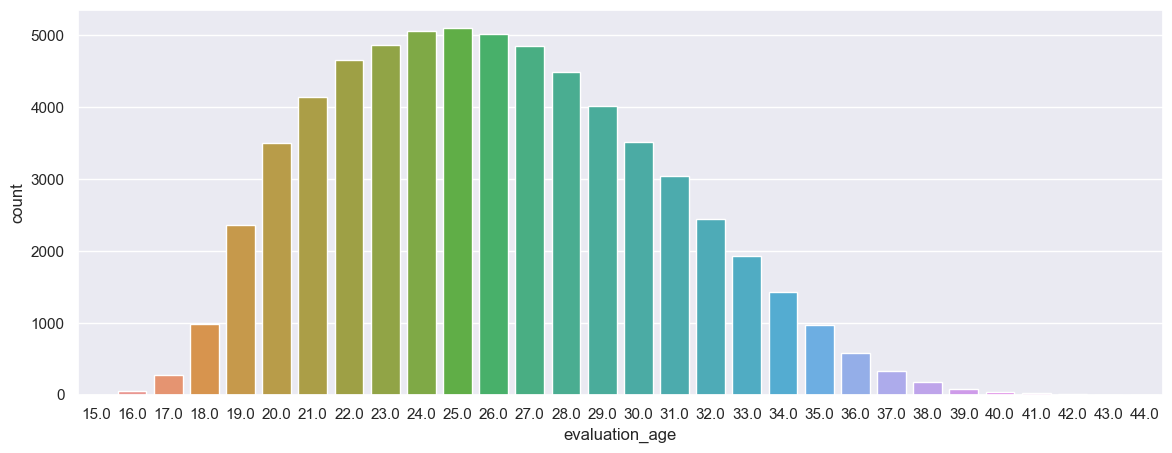

In [15]:
# distribution of player's age at the year of market evaluation
plt.figure(figsize=(14,5))
sns.countplot(x=pre_processed_df['evaluation_age'])

<AxesSubplot:xlabel='position', ylabel='count'>

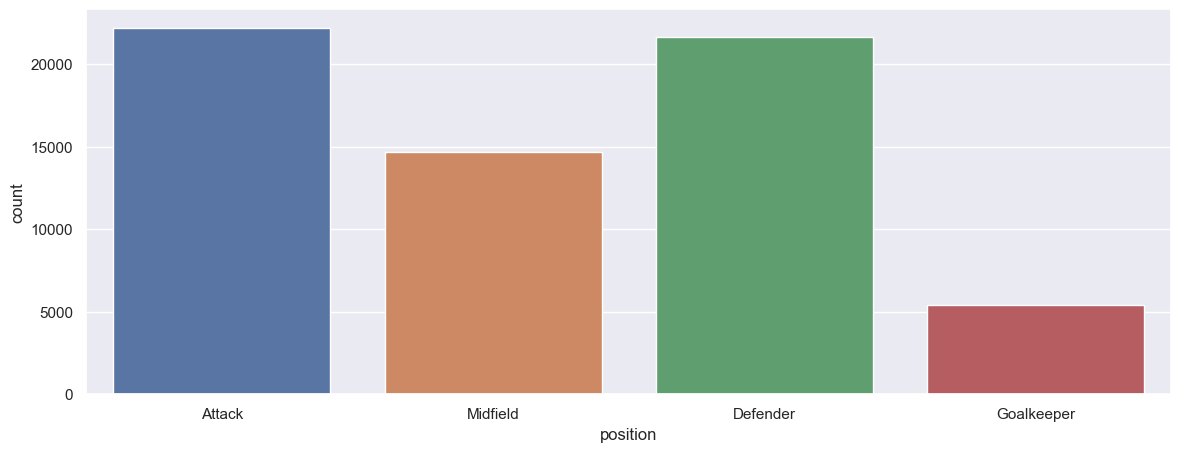

In [16]:
# count of player's position
plt.figure(figsize=(14,5))
sns.countplot(x=pre_processed_df['position'])

Text(0.5, 0, 'market_value_in_million')

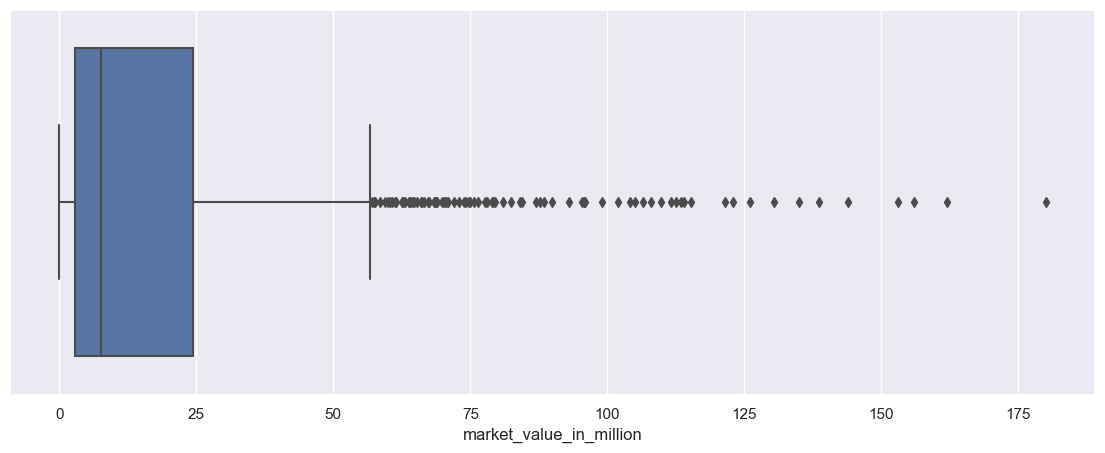

In [17]:
# boxplot to show outliers in market_value_in_million column
plt.figure(figsize=(14,5))
unique_market_value = pre_processed_df['market_value_in_million'].unique()
sns.boxplot(x=unique_market_value)
plt.xlabel('market_value_in_million')

The reason there are so many outliers in market value is that there are a few players who are outstanding and evaluated at a higher value.

#### Bivariate analysis

Text(0, 0.5, 'club_total_market_value_in_million')

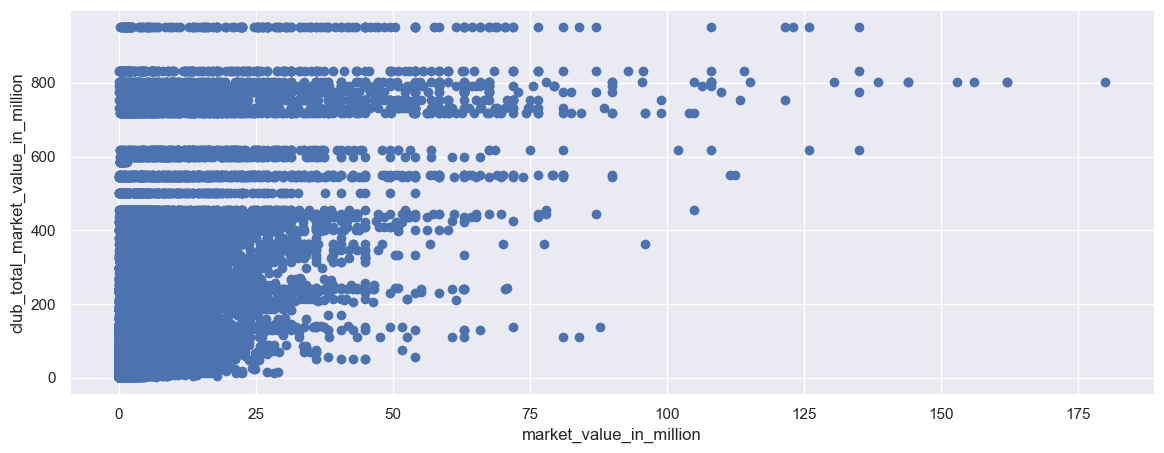

In [18]:
# scatter plot showing relationship between club's total market value and player's market value
plt.figure(figsize=(14,5))
plt.scatter(pre_processed_df['market_value_in_million'], pre_processed_df['club_total_market_value_in_million'])
plt.xlabel('market_value_in_million')
plt.ylabel('club_total_market_value_in_million')

As we can see from the scatter plot above, players' market value tends to increase as their current club's total market value increases. In other words, players from popular and wealthy clubs will be more likely evaluated at a higher value.

Text(0, 0.5, 'goals')

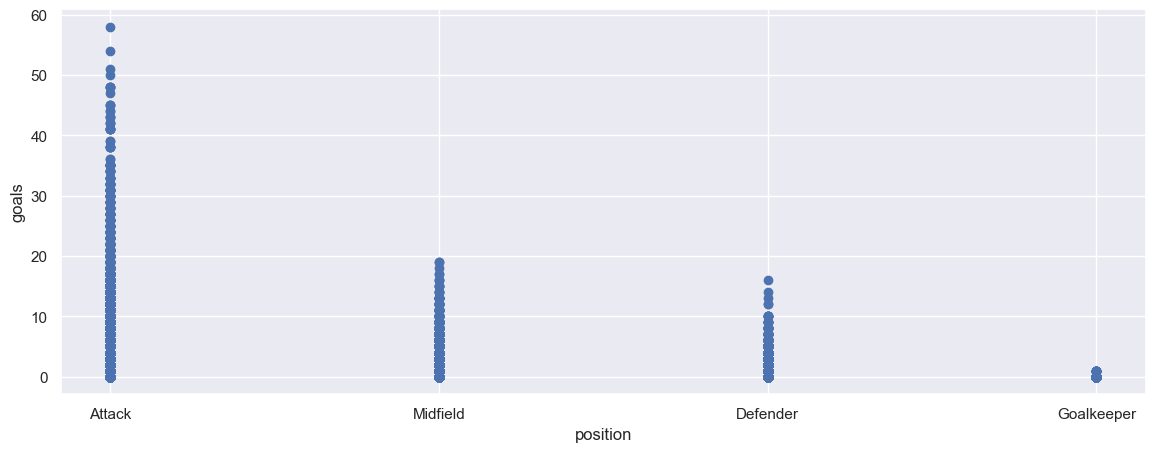

In [19]:
# scatter plot showing relationship between player's position and goals
plt.figure(figsize=(14,5))
plt.scatter(pre_processed_df['position'], pre_processed_df['goals'])
plt.xlabel('position')
plt.ylabel('goals')

Obviously, attack position tends to have more goals than other positions.

#### Other analysis

<AxesSubplot:>

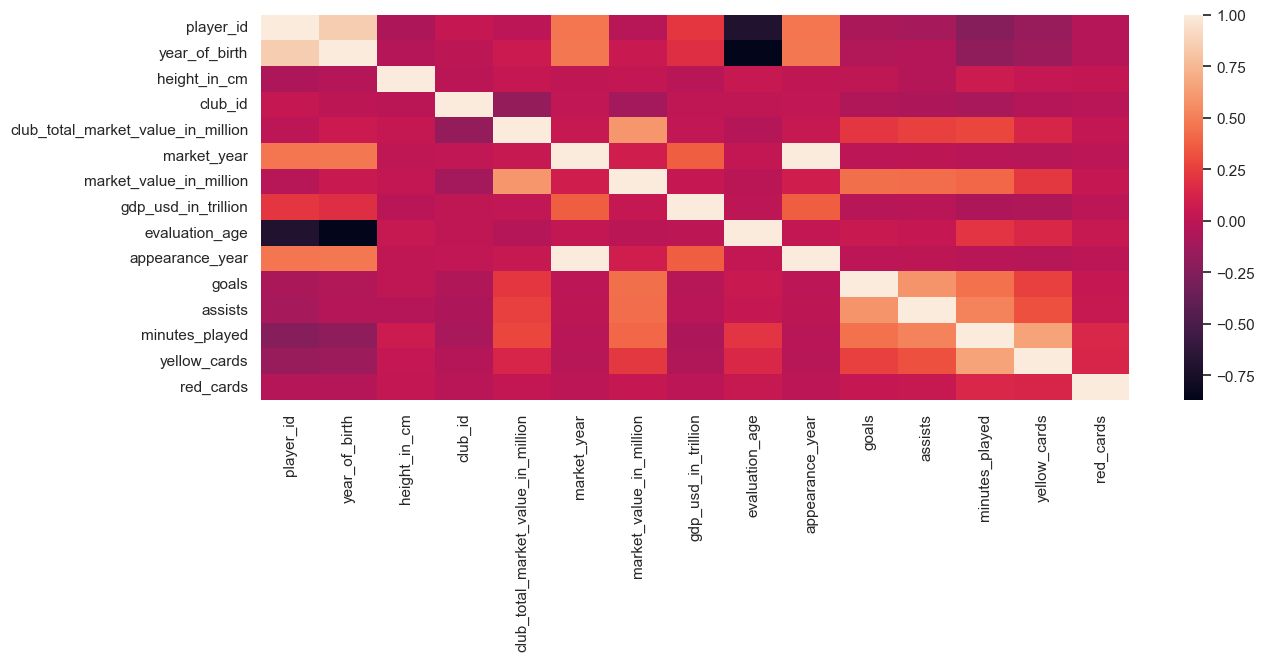

In [20]:
# heatmap of pre-processed dataset
plt.figure(figsize=(14,5))
sns.heatmap(pre_processed_df.corr())

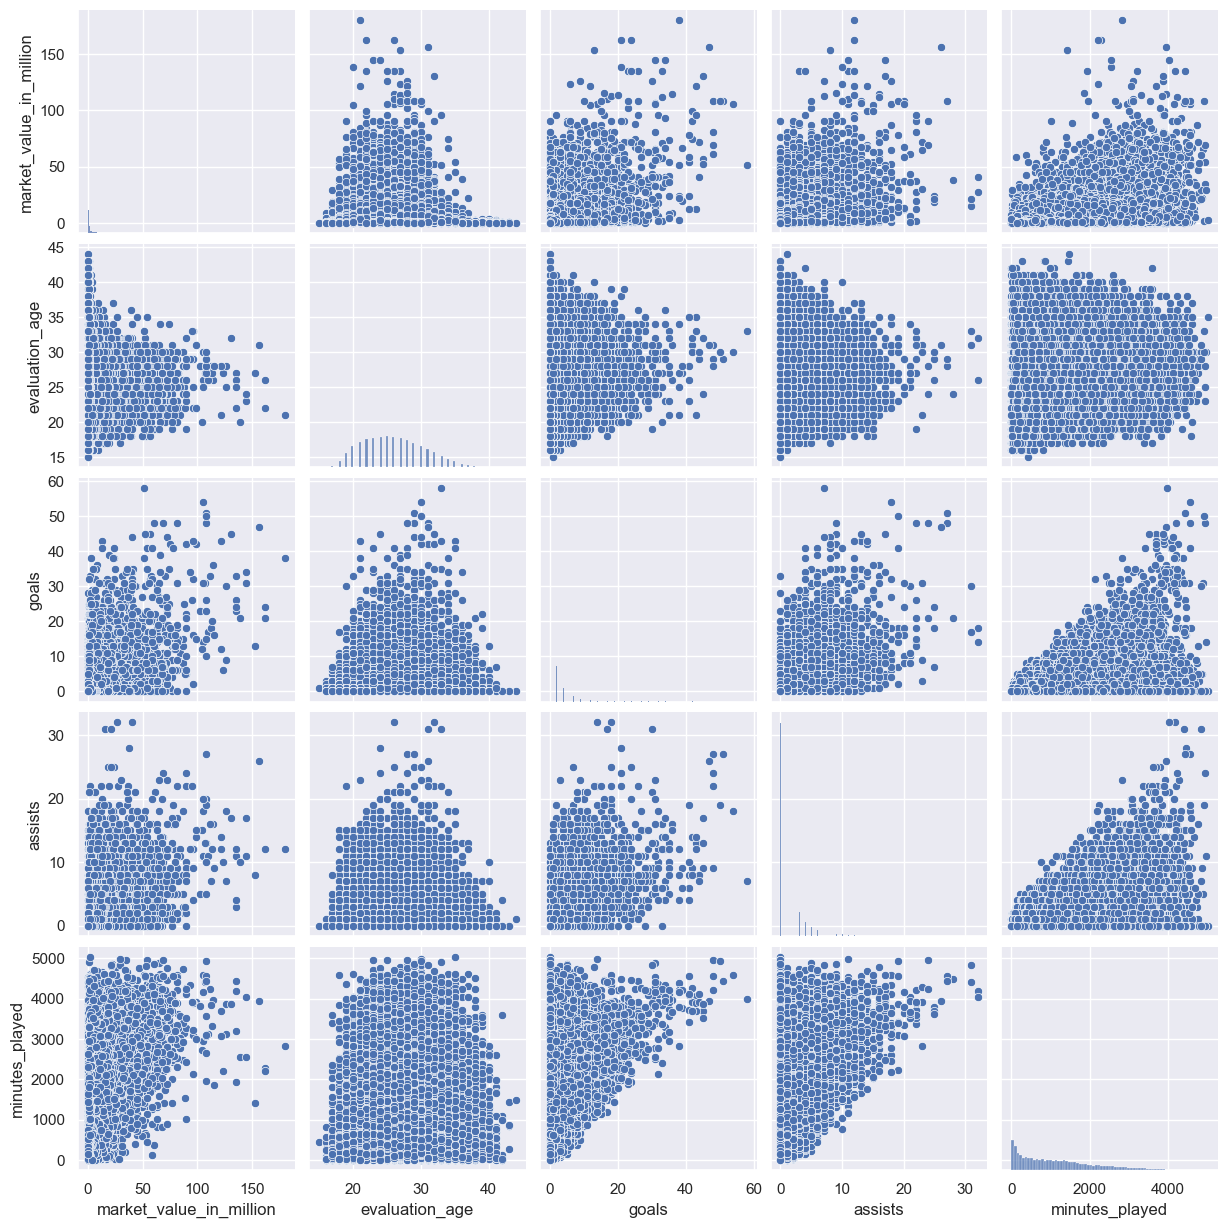

In [21]:
# correlation matrix on subset of columns of pre-processed dataset
subset_df = pre_processed_df[['market_value_in_million', 'evaluation_age', 'goals', 'assists', 'minutes_played']]
sns.pairplot(subset_df)
plt.show()